In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchio as tio
from tqdm.notebook import tqdm
import nibabel as nib


In [2]:

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# Fix random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Get device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [3]:

# --------- UTILITY FUNCTIONS ---------

def check_nii_file(file_path):
    """Check if a NIfTI file is valid and has data."""
    try:
        # Load with nibabel first to check
        img = nib.load(file_path)
        data = img.get_fdata()
        
        # Check if the volume has reasonable dimensions and isn't empty
        if data.size == 0:
            return False, f"Empty volume"
        
        if len(data.shape) != 3:
            return False, f"Wrong dimensions: {data.shape}"
            
        if np.all(data == 0):
            return False, f"All zeros"
            
        if data.shape[0] < 50 or data.shape[1] < 50 or data.shape[2] < 50:
            return False, f"Too small: {data.shape}"
            
        return True, "Valid"
        
    except Exception as e:
        return False, f"Error: {str(e)}"

def validate_dataset_files(csv_path, verbose=True):
    """Validate all MRI files in the dataset and create a cleaned version."""
    df = pd.read_csv(csv_path)
    
    valid_files = []
    invalid_files = []
    
    print(f"Validating {len(df)} files...")
    
    for idx, row in df.iterrows():
        mri_path = row['MRI_PATH']
        is_valid, reason = check_nii_file(mri_path)
        
        if is_valid:
            valid_files.append(row)
        else:
            invalid_files.append((mri_path, reason))
            if verbose:
                print(f"Invalid file {idx}: {mri_path} - {reason}")
    
    print(f"Valid files: {len(valid_files)}")
    print(f"Invalid files: {len(invalid_files)}")
    
    # Create cleaned dataset
    if valid_files:
        clean_df = pd.DataFrame(valid_files)
        clean_path = csv_path.replace('.csv', '_cleaned.csv')
        clean_df.to_csv(clean_path, index=False)
        print(f"Cleaned dataset saved to: {clean_path}")
        return clean_df, clean_path
    else:
        print("No valid files found!")
        return None, None


In [4]:

# --------- DATA PREPARATION ---------

def match_mri_paths(phenotype_csv, mri_root, site_name):
    """Match subjects in phenotypic data with their MRI scans."""
    df = pd.read_csv(phenotype_csv)
    df.columns = df.columns.str.strip()
    df['SUB_ID'] = df['SUB_ID'].astype(str)

    matched = []
    for subj_folder in os.listdir(mri_root):
        subj_path = os.path.join(mri_root, subj_folder)
        if os.path.isdir(subj_path) and subj_folder in df['SUB_ID'].values:
            mri_file = os.path.join(subj_path, "session_1", "anat_1", "anat.nii.gz")
            if os.path.exists(mri_file):
                # Validate the file before adding
                is_valid, _ = check_nii_file(mri_file)
                if is_valid:
                    meta = df[df['SUB_ID'] == subj_folder].iloc[0]
                    matched.append({
                        "SITE": site_name,
                        "SUB_ID": subj_folder,
                        "DIAGNOSIS": meta['DX_GROUP'],
                        "AGE": meta['AGE_AT_SCAN'],
                        "SEX": meta['SEX'],
                        "FIQ": meta['FIQ'],
                        "MRI_PATH": mri_file
                    })
    return pd.DataFrame(matched)

def setup_dataset():
    """Setup the complete dataset with validation."""
    nyu_csv_path = r"E:\Msc_Proj\ABIDEII-NYU_1\ABIDEII-NYU_1.csv"
    nyu_root = r"E:\Msc_Proj\ABIDEII-NYU_1\ABIDEII-NYU_1"

    nyu2_csv_path = r"E:\Msc_Proj\ABIDEII-NYU_2\ABIDEII-NYU_2.csv"
    nyu2_root = r"E:\Msc_Proj\ABIDEII-NYU_2\ABIDEII-NYU_2"

    ucla_csv_path = r"E:\Msc_Proj\ABIDEII-UCLA_1\ABIDEII-UCLA_1.csv"
    ucla_root = r"E:\Msc_Proj\ABIDEII-UCLA_1\ABIDEII-UCLA_1"

    # Match and merge with validation
    print("Matching NYU...")
    df_nyu = match_mri_paths(nyu_csv_path, nyu_root, "NYU")
    print("Matching NYU2...")
    df_nyu2 = match_mri_paths(nyu2_csv_path, nyu2_root, "NYU2")
    print("Matching UCLA...")
    df_ucla = match_mri_paths(ucla_csv_path, ucla_root, "UCLA")

    df_combined = pd.concat([df_nyu, df_nyu2, df_ucla], ignore_index=True)

    # Filter valid data
    df_filtered = df_combined[df_combined['FIQ'].notna() & df_combined['DIAGNOSIS'].isin([1, 2])]
    
    # Convert to 0/1: ASD = 1, Control = 0
    df_filtered.loc[:, 'LABEL'] = df_filtered['DIAGNOSIS'].map({1: 1, 2: 0})

    print(f"Total subjects before validation: {len(df_filtered)}")

    # Stratified split
    train_df, temp_df = train_test_split(df_filtered, test_size=0.3, stratify=df_filtered['LABEL'], random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['LABEL'], random_state=42)

    # Save and validate splits
    train_df.to_csv("E:/Msc_Proj/abide_train.csv", index=False)
    val_df.to_csv("E:/Msc_Proj/abide_val.csv", index=False)
    test_df.to_csv("E:/Msc_Proj/abide_test.csv", index=False)

    print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
    
    # Validate each split
    print("\nValidating training set...")
    train_clean, train_clean_path = validate_dataset_files("E:/Msc_Proj/abide_train.csv")
    print("\nValidating validation set...")
    val_clean, val_clean_path = validate_dataset_files("E:/Msc_Proj/abide_val.csv")
    print("\nValidating test set...")
    test_clean, test_clean_path = validate_dataset_files("E:/Msc_Proj/abide_test.csv")
    
    return train_clean, val_clean, test_clean

In [5]:
# --------- DATASET VISUALIZATION ---------

def visualize_dataset_demographics(train_df, val_df, test_df):
    """Create visualizations for demographic information."""
    # Combine datasets with set labels
    train_df_viz = train_df.copy()
    val_df_viz = val_df.copy()
    test_df_viz = test_df.copy()
    
    train_df_viz['Set'] = 'Train'
    val_df_viz['Set'] = 'Validation'
    test_df_viz['Set'] = 'Test'
    
    all_data = pd.concat([train_df_viz, val_df_viz, test_df_viz], ignore_index=True)
    
    # Create figure with multiple plots
    fig = plt.figure(figsize=(18, 12))
    
    # 1. Diagnosis distribution
    plt.subplot(2, 3, 1)
    sns.countplot(data=all_data, x='Set', hue='DIAGNOSIS')
    plt.title('Diagnosis Distribution by Set')
    plt.ylabel('Count')
    plt.legend(['ASD', 'Control'])
    
    # 2. Age distribution by diagnosis
    plt.subplot(2, 3, 2)
    sns.boxplot(data=all_data, x='DIAGNOSIS', y='AGE')
    plt.title('Age Distribution by Diagnosis')
    plt.xlabel('Diagnosis (1=ASD, 2=Control)')
    plt.ylabel('Age')
    
    # 3. Sex distribution
    plt.subplot(2, 3, 3)
    sns.countplot(data=all_data, x='DIAGNOSIS', hue='SEX')
    plt.title('Sex Distribution by Diagnosis')
    plt.xlabel('Diagnosis (1=ASD, 2=Control)')
    plt.legend(['Male', 'Female'])
    
    # 4. FIQ distribution
    plt.subplot(2, 3, 4)
    sns.boxplot(data=all_data, x='DIAGNOSIS', y='FIQ')
    plt.title('IQ Distribution by Diagnosis')
    plt.xlabel('Diagnosis (1=ASD, 2=Control)')
    plt.ylabel('Full-scale IQ')
    
    # 5. Site distribution
    plt.subplot(2, 3, 5)
    sns.countplot(data=all_data, x='SITE', hue='DIAGNOSIS')
    plt.title('Site Distribution')
    plt.xticks(rotation=45)
    plt.legend(['ASD', 'Control'])
    
    # 6. Age distribution across sets
    plt.subplot(2, 3, 6)
    sns.boxplot(data=all_data, x='Set', y='AGE')
    plt.title('Age Distribution by Set')
    
    plt.tight_layout()
    plt.savefig('E:/Msc_Proj/demographics_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

In [ ]:

# ---------  DATASET CLASS ---------

class ABIDEDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        self.transform = transform
        
        # Load and validate the data
        df = pd.read_csv(csv_path)
        
        # Pre-validate all files
        print(f"Pre-validating {len(df)} files...")
        valid_data = []
        
        for idx, row in df.iterrows():
            is_valid, reason = check_nii_file(row['MRI_PATH'])
            if is_valid:
                valid_data.append(row)
            else:
                print(f"Skipped invalid file {idx}: {reason}")
        
        self.data = pd.DataFrame(valid_data).reset_index(drop=True)
        self.data['LABEL'] = self.data['LABEL'].astype(int)
        
        print(f"Dataset initialized with {len(self.data)} valid samples")
        
        if len(self.data) == 0:
            raise ValueError("No valid samples found in dataset!")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """Get the MRI volume and label for a given index."""
        row = self.data.iloc[idx]
        
        try:
            # Load the MRI using torchio
            subject = tio.Subject(
                mri=tio.ScalarImage(row['MRI_PATH']),
                label=torch.tensor(row['LABEL'], dtype=torch.float32)
            )
            
            # Verify the loaded data
            if subject.mri.data.numel() == 0:
                raise ValueError(f"Empty volume loaded from {row['MRI_PATH']}")
            
            # Apply transforms
            if self.transform:
                subject = self.transform(subject)
            
            # Final verification after transforms
            if subject.mri.data.numel() == 0:
                raise ValueError(f"Volume became empty after transforms")
            
            return subject.mri.data, subject.label
            
        except Exception as e:
            print(f"Error loading sample {idx} ({row['SUB_ID']}): {str(e)}")
            # Return a dummy sample instead of failing
            dummy_volume = torch.zeros((1, 96, 96, 96))
            return dummy_volume, torch.tensor(0.0)

In [7]:
# --------- VISUALIZATION FUNCTIONS ---------

def visualize_mri_sample(dataset, idx=0, slices=(0.3, 0.5, 0.7)):
    """Visualize a single MRI scan with multiple slices."""
    try:
        image, label = dataset[idx]
        
        # Handle case where image might be empty
        if image.numel() == 0:
            print(f"Sample {idx} is empty, trying next sample...")
            return visualize_mri_sample(dataset, (idx + 1) % len(dataset), slices)
        
        image = image.squeeze().numpy()  # Remove channel dimension
        
        # Get metadata
        row = dataset.data.iloc[idx]
        diagnosis = "ASD" if row['LABEL'] == 1 else "Control"
        subject_id = row['SUB_ID']
        age = row['AGE']
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Get dimensions
        if len(image.shape) == 3:
            d, h, w = image.shape
        else:
            print(f"Unexpected image shape: {image.shape}")
            return None
        
        # Calculate slice indices
        slice_indices = [int(s * d) for s in slices]
        
        for i, (ax, slice_idx) in enumerate(zip(axes, slice_indices)):
            if slice_idx < d:
                ax.imshow(image[slice_idx, :, :], cmap='gray')
                ax.set_title(f'Slice {slice_idx}/{d}')
            else:
                ax.text(0.5, 0.5, 'Invalid slice', ha='center', va='center', transform=ax.transAxes)
            ax.axis('off')
        
        plt.suptitle(f'Subject {subject_id} - {diagnosis} - Age: {age}')
        plt.tight_layout()
        plt.savefig(f'E:/Msc_Proj/sample_visualization_{idx}.png', dpi=300, bbox_inches='tight')
        plt.show()
        return fig
        
    except Exception as e:
        print(f"Error visualizing sample {idx}: {str(e)}")
        return None

def visualize_batch(dataloader, max_samples=4):
    """Visualize a batch of MRI scans."""
    try:
        batch_images, batch_labels = next(iter(dataloader))
        batch_size = min(batch_images.shape[0], max_samples)
        
        if batch_size == 0:
            print("Empty batch!")
            return None
        
        fig, axes = plt.subplots(batch_size, 3, figsize=(15, 5*batch_size))
        if batch_size == 1:
            axes = axes.reshape(1, -1)
        
        for i in range(batch_size):
            try:
                image = batch_images[i, 0].numpy()  # Get first channel
                label = batch_labels[i].item()
                diagnosis = "ASD" if label == 1 else "Control"
                
                # Get center slices
                if image.size > 0:
                    d, h, w = image.shape
                    slices = [d//4, d//2, 3*d//4]
                    
                    for j, slice_idx in enumerate(slices):
                        ax = axes[i, j]
                        if slice_idx < d:
                            ax.imshow(image[slice_idx, :, :], cmap='gray')
                            ax.set_title(f'Sample {i+1} - {diagnosis} - Slice {slice_idx}')
                        else:
                            ax.text(0.5, 0.5, 'Invalid', ha='center', va='center', transform=ax.transAxes)
                        ax.axis('off')
                else:
                    for j in range(3):
                        axes[i, j].text(0.5, 0.5, 'Empty', ha='center', va='center', transform=axes[i, j].transAxes)
                        axes[i, j].axis('off')
            except Exception as e:
                print(f"Error processing sample {i}: {str(e)}")
                for j in range(3):
                    axes[i, j].text(0.5, 0.5, 'Error', ha='center', va='center', transform=axes[i, j].transAxes)
                    axes[i, j].axis('off')
        
        plt.tight_layout()
        plt.savefig('E:/Msc_Proj/batch_visualization.png', dpi=300, bbox_inches='tight')
        plt.show()
        return fig
        
    except Exception as e:
        print(f"Error visualizing batch: {str(e)}")
        return None



In [ ]:

# --------- MODEL ARCHITECTURE ---------

class ResidualBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=False):
        super(ResidualBlock3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)

        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm3d(out_channels)
            )

        self.dropout = nn.Dropout3d(p=0.3) if dropout else nn.Identity()

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.dropout(out)
        if self.downsample:
            identity = self.downsample(identity)
        out += identity
        return self.relu(out)

class ASDClassifier3D(nn.Module):
    def __init__(self):
        super(ASDClassifier3D, self).__init__()
        self.encoder = nn.Sequential(
            ResidualBlock3D(1, 16),
            nn.MaxPool3d(2),
            ResidualBlock3D(16, 32, dropout=True),
            nn.MaxPool3d(2),
            ResidualBlock3D(32, 64, dropout=True),
            nn.MaxPool3d(2),
            ResidualBlock3D(64, 128, dropout=True)
        )

        self.global_pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
            
        )
        
        # Store activation maps for visualization
        self.activation = {}
        
    def get_activation(self, name):
        def hook(model, input, output):
            self.activation[name] = output.detach()
        return hook
    
    def register_hooks(self):
        # Register hooks to capture intermediate activations
        self.encoder[0].conv2.register_forward_hook(self.get_activation('res1'))
        self.encoder[2].conv2.register_forward_hook(self.get_activation('res2'))
        self.encoder[4].conv2.register_forward_hook(self.get_activation('res3'))
        self.encoder[6].conv2.register_forward_hook(self.get_activation('res4'))

    def forward(self, x):
        # Skip empty tensors
        if x.numel() == 0:
            return torch.tensor([0.5] * x.shape[0], device=x.device)
        
        x = self.encoder(x)
        x = self.global_pool(x)
        return self.classifier(x).squeeze(1)

In [ ]:


# --------- TRAINING FUNCTIONS ---------

def train_epoch(model, train_loader, optimizer, criterion, device):
    """Train model for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    valid_batches = 0
    
    progress_bar = tqdm(train_loader, desc="Training")
    
    for inputs, labels in progress_bar:
        try:
            # Skip empty batches
            if inputs.numel() == 0 or labels.numel() == 0:
                continue
                
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Skip if any input is empty
            if torch.any(torch.sum(inputs.view(inputs.shape[0], -1), dim=1) == 0):
                continue
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            valid_batches += 1
            
            # Update progress bar
            if total > 0:
                progress_bar.set_postfix({"Loss": loss.item(), "Acc": 100 * correct / total})
        
        except Exception as e:
            print(f"Error in training batch: {str(e)}")
            continue
    
    if valid_batches == 0:
        return 0.0, 0.0
    
    epoch_loss = running_loss / valid_batches
    epoch_acc = 100 * correct / total if total > 0 else 0.0
    
    return epoch_loss, epoch_acc

def evaluate(model, data_loader, criterion, device):
    """Evaluate model on validation or test set."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    valid_batches = 0
    
    all_outputs = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            try:
                # Skip empty batches
                if inputs.numel() == 0 or labels.numel() == 0:
                    continue
                    
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Skip if any input is empty
                if torch.any(torch.sum(inputs.view(inputs.shape[0], -1), dim=1) == 0):
                    continue
                raw_outputs = model(inputs)
                outputs = torch.sigmoid(raw_outputs)  # Apply sigmoid here
                loss = criterion(raw_outputs, labels)  # Use raw logits for loss

                
                running_loss += loss.item()
                predicted = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                valid_batches += 1
                
                # Store predictions and labels
                all_outputs.extend(outputs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
            except Exception as e:
                print(f"Error in evaluation batch: {str(e)}")
                continue
    
    if valid_batches == 0:
        return 100.0, 0.0, [], []
    
    epoch_loss = running_loss / valid_batches
    epoch_acc = 100 * correct / total if total > 0 else 0.0
    
    return epoch_loss, epoch_acc, all_outputs, all_labels

In [10]:


# --------- VISUALIZATION OF MODEL PERFORMANCE ---------

def plot_training_history(train_losses, train_accs, val_losses, val_accs):
    """Plot training and validation metrics over epochs."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    epochs = range(1, len(train_losses) + 1)
    
    # Plot losses
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(epochs, train_accs, 'b-', label='Training Accuracy')
    ax2.plot(epochs, val_accs, 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('E:/Msc_Proj/training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    return fig

def plot_confusion_matrix(y_true, y_pred):
    """Plot confusion matrix."""
    if len(y_true) == 0 or len(y_pred) == 0:
        print("No predictions to plot confusion matrix")
        return None
        
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Control', 'ASD'], 
                yticklabels=['Control', 'ASD'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('E:/Msc_Proj/confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    return plt.gcf()

def plot_roc_curve(y_true, y_scores):
    """Plot ROC curve."""
    if len(y_true) == 0 or len(y_scores) == 0:
        print("No predictions to plot ROC curve")
        return None
        
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('E:/Msc_Proj/roc_curve.png', dpi=300, bbox_inches='tight')
    plt.show()
    return plt.gcf()


Assessing data quality before training...
Data Quality Assessment
File not found: E:/Msc_Proj/abide_train.csv
File not found: E:/Msc_Proj/abide_val.csv
File not found: E:/Msc_Proj/abide_test.csv
Cleaned datasets not found, creating new ones...
Matching NYU...
Matching NYU2...
Matching UCLA...


C:\Users\SARGAM\AppData\Local\Temp\ipykernel_35752\250183096.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.loc[:, 'LABEL'] = df_filtered['DIAGNOSIS'].map({1: 1, 2: 0})


Total subjects before validation: 134
Train: 93, Val: 20, Test: 21

Validating training set...
Validating 93 files...
Valid files: 93
Invalid files: 0
Cleaned dataset saved to: E:/Msc_Proj/abide_train_cleaned.csv

Validating validation set...
Validating 20 files...
Valid files: 20
Invalid files: 0
Cleaned dataset saved to: E:/Msc_Proj/abide_val_cleaned.csv

Validating test set...
Validating 21 files...
Valid files: 21
Invalid files: 0
Cleaned dataset saved to: E:/Msc_Proj/abide_test_cleaned.csv
Pre-validating 93 files...
Dataset initialized with 93 valid samples
Pre-validating 20 files...
Dataset initialized with 20 valid samples
Pre-validating 21 files...
Dataset initialized with 21 valid samples
Dataset sizes - Train: 93, Val: 20, Test: 21
Creating demographic visualizations...


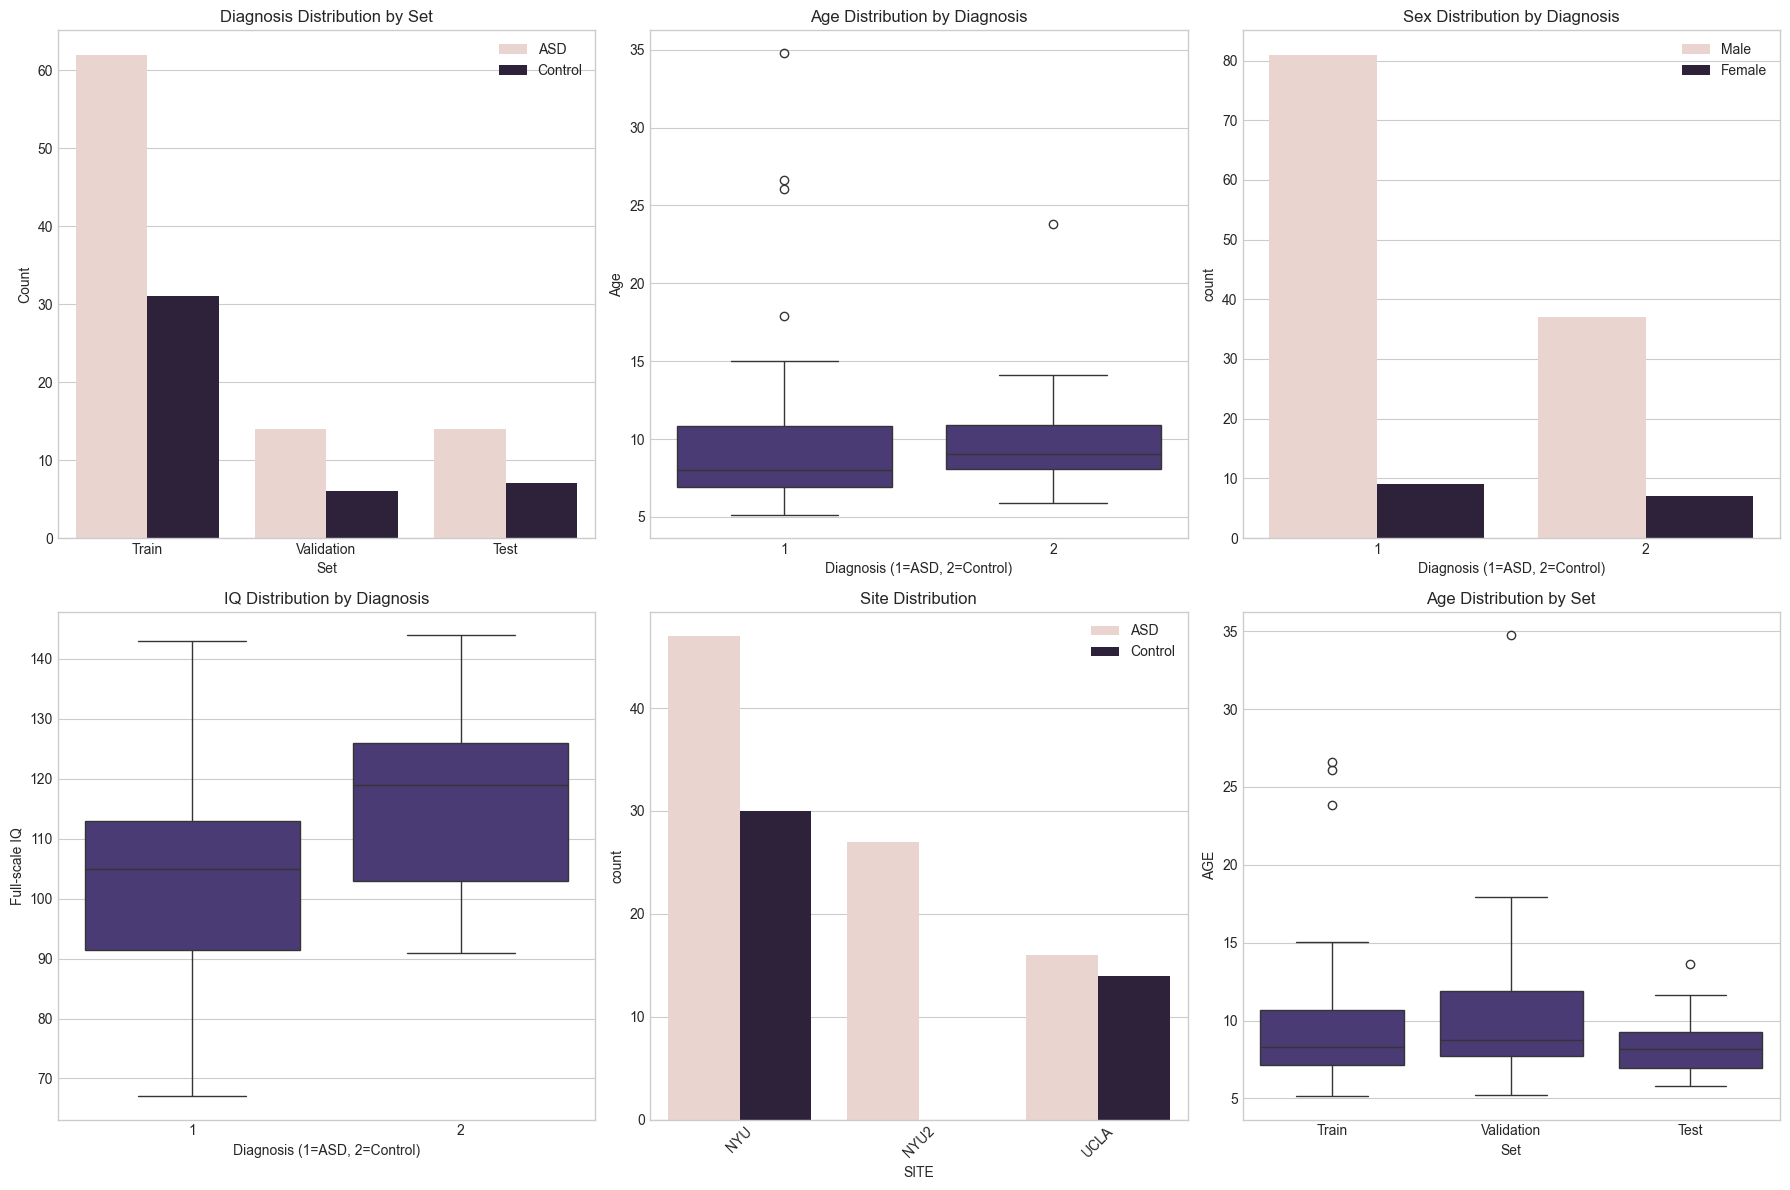

Creating MRI sample visualizations...


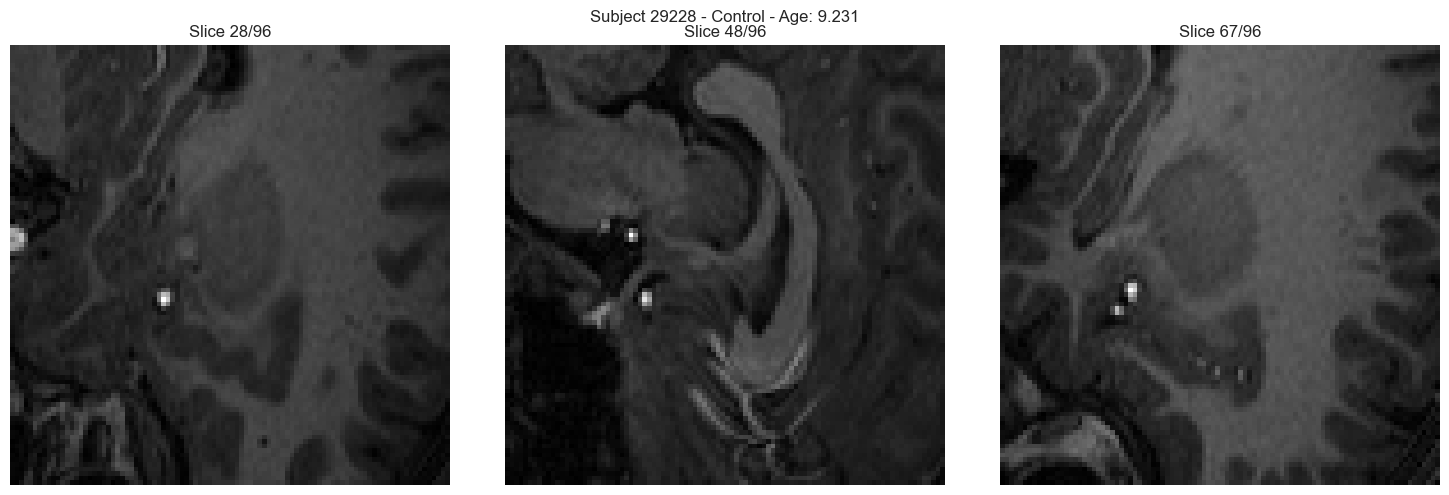

e:\Msc_Proj\env\Lib\site-packages\torchio\data\image.py:248: UserWarning: Using TorchIO images without a torchio.SubjectsLoader in PyTorch >= 2.3 might have unexpected consequences, e.g., the collated batches will be instances of torchio.Subject with 5D images. Replace your PyTorch DataLoader with a torchio.SubjectsLoader so that the collated batch becomes a dictionary, as expected. See https://github.com/TorchIO-project/torchio/issues/1179 for more context about this issue.
  warnings.warn(message, stacklevel=1)


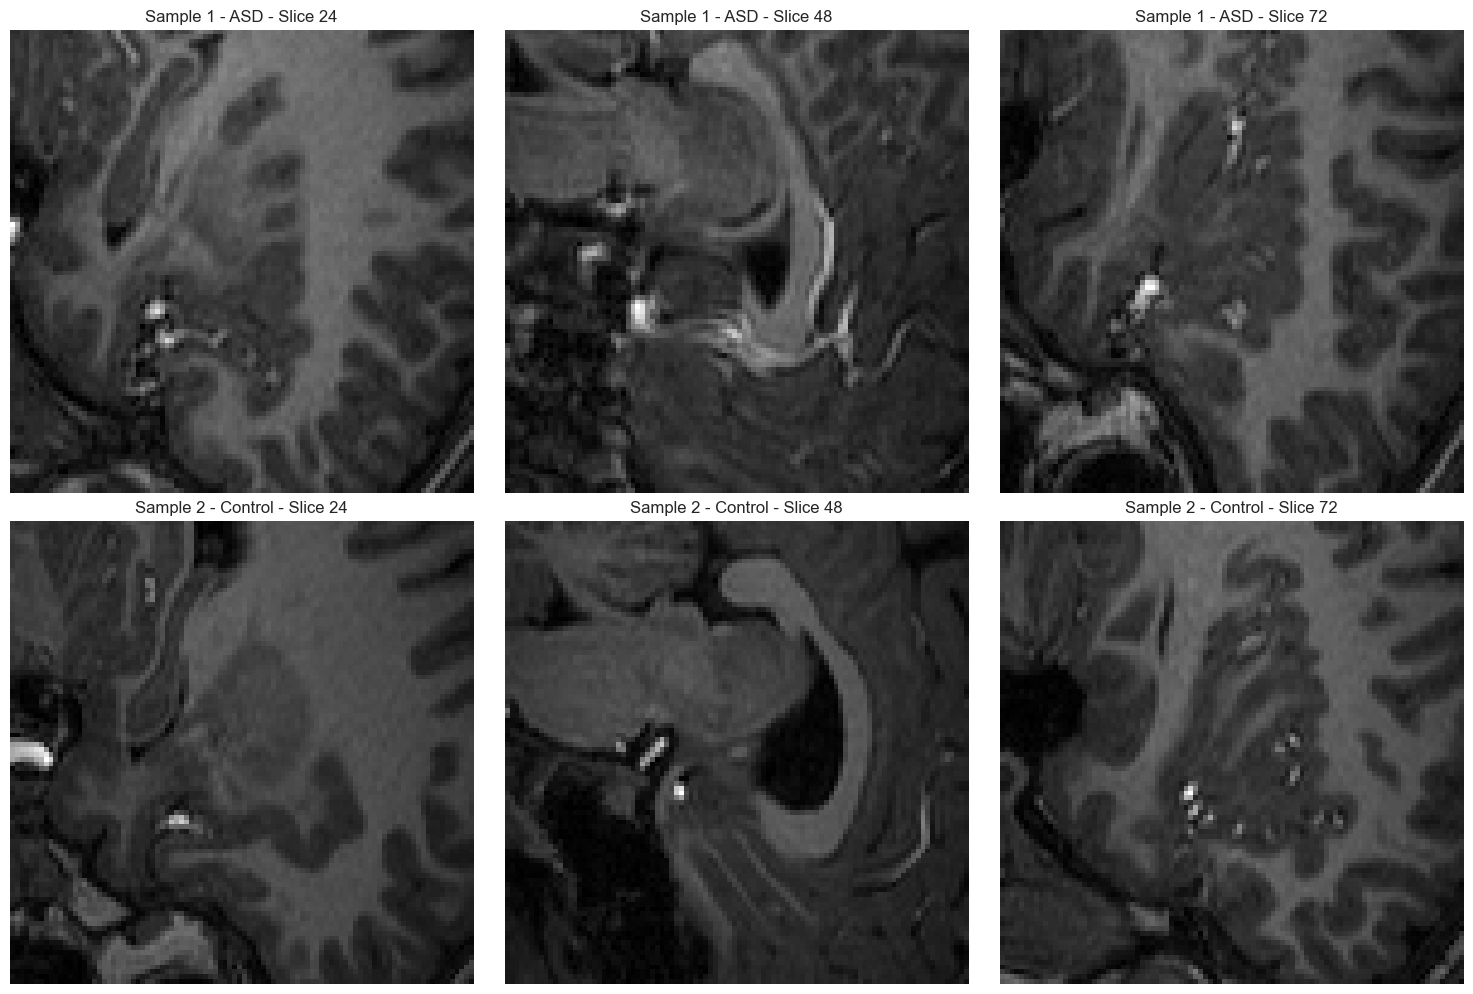

Creating model...
Testing model with dummy data...
Model test successful. Output shape: torch.Size([1])
Starting training...

Epoch 1/10
--------------------------------------------------


Training:   0%|          | 0/47 [00:00<?, ?it/s]

e:\Msc_Proj\env\Lib\site-packages\torchio\data\image.py:248: UserWarning: Using TorchIO images without a torchio.SubjectsLoader in PyTorch >= 2.3 might have unexpected consequences, e.g., the collated batches will be instances of torchio.Subject with 5D images. Replace your PyTorch DataLoader with a torchio.SubjectsLoader so that the collated batch becomes a dictionary, as expected. See https://github.com/TorchIO-project/torchio/issues/1179 for more context about this issue.
  warnings.warn(message, stacklevel=1)


Train Loss: 0.6862, Train Acc: 63.44%
Val Loss: 0.6427, Val Acc: 70.00%
Learning Rate: 0.001000
✓ Saved new best model!

Epoch 2/10
--------------------------------------------------


Training:   0%|          | 0/47 [00:00<?, ?it/s]

Train Loss: 0.6602, Train Acc: 64.52%
Val Loss: 0.6119, Val Acc: 70.00%
Learning Rate: 0.001000

Epoch 3/10
--------------------------------------------------


Training:   0%|          | 0/47 [00:00<?, ?it/s]

Train Loss: 0.6413, Train Acc: 64.52%
Val Loss: 0.6125, Val Acc: 70.00%
Learning Rate: 0.001000


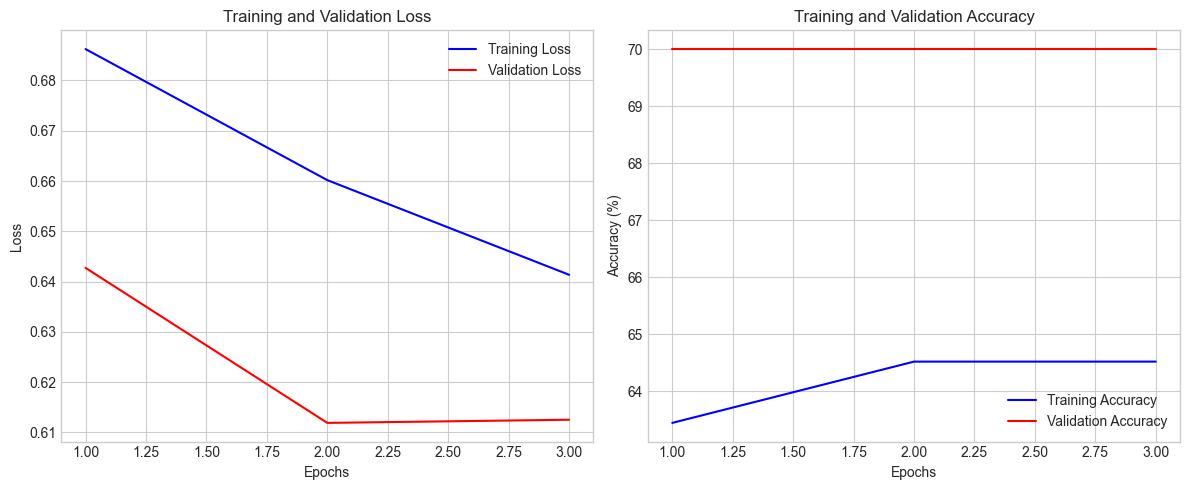


Epoch 4/10
--------------------------------------------------


Training:   0%|          | 0/47 [00:00<?, ?it/s]

Train Loss: 0.6717, Train Acc: 66.67%
Val Loss: 0.6141, Val Acc: 70.00%
Learning Rate: 0.001000

Epoch 5/10
--------------------------------------------------


Training:   0%|          | 0/47 [00:00<?, ?it/s]

Train Loss: 0.6539, Train Acc: 66.67%
Val Loss: 0.6156, Val Acc: 70.00%
Learning Rate: 0.001000

Epoch 6/10
--------------------------------------------------


Training:   0%|          | 0/47 [00:00<?, ?it/s]

Train Loss: 0.6329, Train Acc: 66.67%
Val Loss: 0.6128, Val Acc: 70.00%
Learning Rate: 0.000500
Early stopping triggered after 6 epochs
Loaded best model with validation accuracy: 70.00%
Testing trained model...
Evaluating on test set...
Test Loss: 0.7091, Test Acc: 66.67%
Creating confusion matrix...


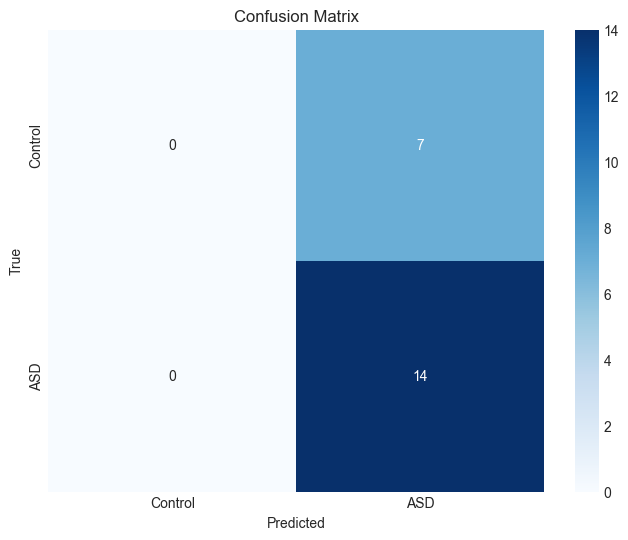

Creating ROC curve...


<Figure size 640x480 with 0 Axes>

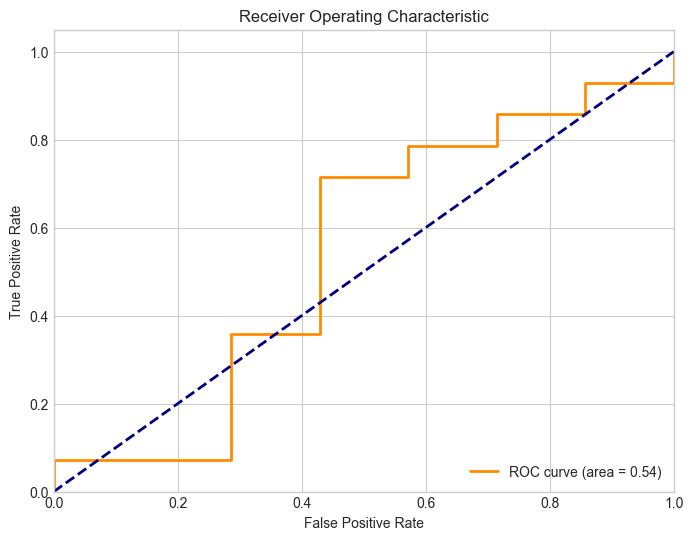

Creating activation visualizations...


e:\Msc_Proj\env\Lib\site-packages\torchio\data\image.py:248: UserWarning: Using TorchIO images without a torchio.SubjectsLoader in PyTorch >= 2.3 might have unexpected consequences, e.g., the collated batches will be instances of torchio.Subject with 5D images. Replace your PyTorch DataLoader with a torchio.SubjectsLoader so that the collated batch becomes a dictionary, as expected. See https://github.com/TorchIO-project/torchio/issues/1179 for more context about this issue.
  warnings.warn(message, stacklevel=1)


<Figure size 640x480 with 0 Axes>

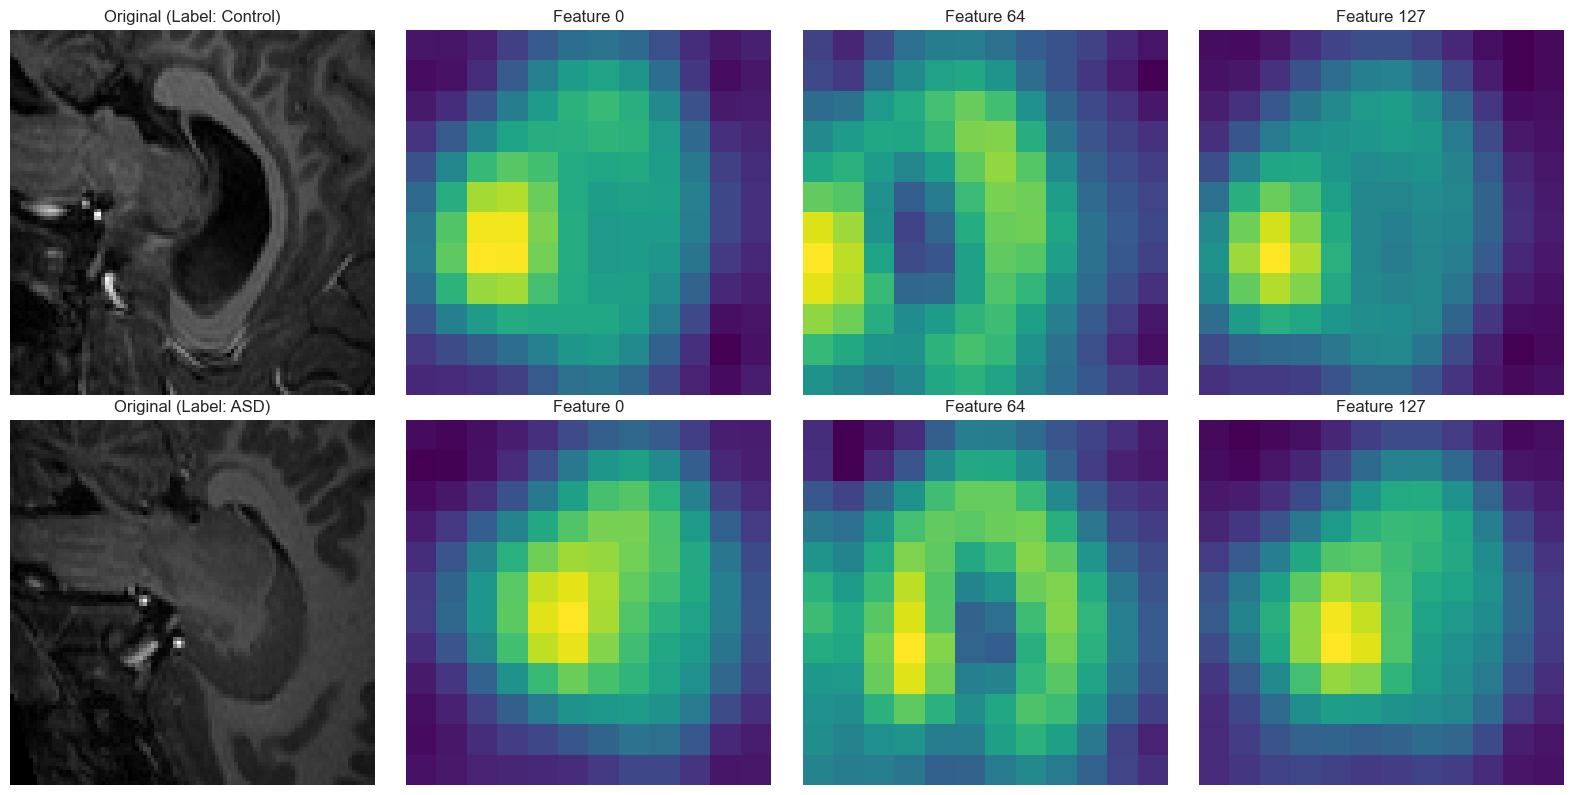

Final test accuracy: 66.67%


In [ ]:

# --------- MAIN EXECUTION ---------

def main():
    """Main function to run the entire pipeline."""
    try:
        # Data transformations - more conservative
        train_transform = tio.Compose([
            tio.RescaleIntensity((0, 1)),
            tio.CropOrPad((96, 96, 96)),
            tio.RandomFlip(axes=('LR',), flip_probability=0.3),
            tio.ZNormalization()
        ])

        val_transform = tio.Compose([
            tio.RescaleIntensity((0, 1)),
            tio.CropOrPad((96, 96, 96)),
            tio.ZNormalization()
        ])
        
        # Try to load existing cleaned datasets first
        try:
            train_dataset = ABIDEDataset("E:/Msc_Proj/abide_train_cleaned.csv", transform=train_transform)
            val_dataset = ABIDEDataset("E:/Msc_Proj/abide_val_cleaned.csv", transform=val_transform)
            test_dataset = ABIDEDataset("E:/Msc_Proj/abide_test_cleaned.csv", transform=val_transform)
        except FileNotFoundError:
            print("Cleaned datasets not found, creating new ones...")
            train_clean, val_clean, test_clean = setup_dataset()
            if train_clean is None:
                print("Failed to create valid datasets!")
                return
            
            train_dataset = ABIDEDataset("E:/Msc_Proj/abide_train_cleaned.csv", transform=train_transform)
            val_dataset = ABIDEDataset("E:/Msc_Proj/abide_val_cleaned.csv", transform=val_transform)
            test_dataset = ABIDEDataset("E:/Msc_Proj/abide_test_cleaned.csv", transform=val_transform)
        
        print(f"Dataset sizes - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")
        
        if len(train_dataset) == 0:
            print("No valid training samples found!")
            return
        
        # Create dataloaders with error handling
        train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=2, num_workers=0)
        test_loader = DataLoader(test_dataset, batch_size=2, num_workers=0)
        
        # Visualize dataset demographics
        print("Creating demographic visualizations...")
        visualize_dataset_demographics(
            train_dataset.data,
            val_dataset.data,
            test_dataset.data
        )
        
        # Visualize MRI samples
        print("Creating MRI sample visualizations...")
        visualize_mri_sample(train_dataset, idx=0)
        visualize_batch(train_loader)
        
        # Create and test model
        print("Creating model...")
        model = ASDClassifier3D()
        
        # Test model with a small batch first
        print("Testing model with dummy data...")
        dummy_input = torch.randn(1, 1, 96, 96, 96).to(device)
        model = model.to(device)
        
        with torch.no_grad():
            test_output = model(dummy_input)
            print(f"Model test successful. Output shape: {test_output.shape}")
        
        # Train model
        print("Starting training...")
        trained_model, train_losses, train_accs, val_losses, val_accs = train_model(
            model, train_loader, val_loader, num_epochs=10  # Reduced epochs for testing
        )
        
        # Test model
        print("Testing trained model...")
        test_loss, test_acc = test_model(trained_model, test_loader)
        
        print(f"Final test accuracy: {test_acc:.2f}%")
        
    except Exception as e:
        print(f"Error in main execution: {str(e)}")
        import traceback
        traceback.print_exc()

def train_model(model, train_loader, val_loader, num_epochs=10):
    """Full training pipeline with visualizations."""
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
    
    # For tracking metrics
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    best_val_acc = 0.0
    patience_counter = 0
    max_patience = 5
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 50)
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validate
        val_loss, val_acc, val_outputs, val_labels = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Update learning rate
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"Learning Rate: {current_lr:.6f}")
        
        # Early stopping and model saving
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'E:/Msc_Proj/best_model.pth')
            print("✓ Saved new best model!")
        else:
            patience_counter += 1
            if patience_counter >= max_patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
        
        # Visualize training progress every 3 epochs
        if (epoch + 1) % 3 == 0 or epoch == num_epochs - 1:
            plot_training_history(train_losses, train_accs, val_losses, val_accs)
    
    # Load best model
    if os.path.exists('E:/Msc_Proj/best_model.pth'):
        model.load_state_dict(torch.load('E:/Msc_Proj/best_model.pth'))
        print(f"Loaded best model with validation accuracy: {best_val_acc:.2f}%")
    
    return model, train_losses, train_accs, val_losses, val_accs

def test_model(model, test_loader):
    """Test the model and create visualizations."""
    model = model.to(device)
    # Compute pos_weight dynamically using training labels
    label_counts = train_dataset.data['LABEL'].value_counts()
    pos_weight = torch.tensor([label_counts[0] / label_counts[1]]).to(device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    print("Evaluating on test set...")
    test_loss, test_acc, test_outputs, test_labels = evaluate(model, test_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    
    if len(test_outputs) > 0 and len(test_labels) > 0:
        # Convert to binary predictions
        test_preds = [1 if o > 0.5 else 0 for o in test_outputs]
        
        # Create confusion matrix
        print("Creating confusion matrix...")
        plot_confusion_matrix(test_labels, test_preds)
        
        # Create ROC curve
        print("Creating ROC curve...")
        plot_roc_curve(test_labels, test_outputs)
        
        # Visualize activation maps if possible
        try:
            print("Creating activation visualizations...")
            visualize_activation(model, test_loader, device)
        except Exception as e:
            print(f"Could not create activation visualizations: {str(e)}")
    else:
        print("No valid test predictions to visualize")
    
    return test_loss, test_acc

def visualize_activation(model, loader, device, layer_name='res4'):
    """Visualize activation maps from a specific layer."""
    try:
        model.eval()
        model.register_hooks()
        
        # Get a batch and run through model
        inputs, labels = next(iter(loader))
        
        # Only use samples that aren't empty
        valid_indices = []
        for i in range(inputs.shape[0]):
            if inputs[i].sum() != 0:
                valid_indices.append(i)
        
        if len(valid_indices) == 0:
            print("No valid samples for activation visualization")
            return None
        
        # Take up to 2 valid samples
        valid_indices = valid_indices[:2]
        inputs = inputs[valid_indices].to(device)
        labels = labels[valid_indices]
        
        with torch.no_grad():
            _ = model(inputs)
        
        # Get activation
        if layer_name not in model.activation:
            print(f"Layer {layer_name} not found in activations")
            return None
            
        activation = model.activation[layer_name]
        
        # Set up the figure
        n_samples = len(valid_indices)
        fig, axes = plt.subplots(n_samples, 4, figsize=(16, 4*n_samples))
        if n_samples == 1:
            axes = axes.reshape(1, -1)
        
        for sample_idx in range(n_samples):
            # Original MRI
            original = inputs[sample_idx, 0].cpu().numpy()
            d = original.shape[0] // 2  # Middle slice
            
            axes[sample_idx, 0].imshow(original[d, :, :], cmap='gray')
            axes[sample_idx, 0].set_title(f"Original (Label: {'ASD' if labels[sample_idx]==1 else 'Control'})")
            axes[sample_idx, 0].axis('off')
            
            # Show 3 different feature maps
            feature_maps = activation[sample_idx].cpu().numpy()
            n_features = feature_maps.shape[0]
            
            # Choose 3 feature maps to display
            for i, feature_idx in enumerate([0, n_features//2, n_features-1]):
                feature = feature_maps[feature_idx]
                d_feat = feature.shape[0] // 2  # Middle slice
                
                axes[sample_idx, i+1].imshow(feature[d_feat, :, :], cmap='viridis')
                axes[sample_idx, i+1].set_title(f"Feature {feature_idx}")
                axes[sample_idx, i+1].axis('off')
        
        plt.tight_layout()
        plt.savefig(f'E:/Msc_Proj/activation_{layer_name}.png', dpi=300, bbox_inches='tight')
        plt.show()
        return fig
        
    except Exception as e:
        print(f"Error in activation visualization: {str(e)}")
        return None

# Additional utility function for data quality assessment
def assess_data_quality(csv_paths):
    """Assess the quality of the dataset files."""
    print("Data Quality Assessment")
    print("=" * 50)
    
    for csv_path in csv_paths:
        if not os.path.exists(csv_path):
            print(f"File not found: {csv_path}")
            continue
            
        df = pd.read_csv(csv_path)
        print(f"\nDataset: {os.path.basename(csv_path)}")
        print(f"Total samples: {len(df)}")
        
        # Check file existence
        existing_files = 0
        valid_files = 0
        empty_files = 0
        error_files = 0
        
        for _, row in df.iterrows():
            mri_path = row['MRI_PATH']
            if os.path.exists(mri_path):
                existing_files += 1
                is_valid, reason = check_nii_file(mri_path)
                if is_valid:
                    valid_files += 1
                elif "Empty" in reason or "zeros" in reason:
                    empty_files += 1
                else:
                    error_files += 1
        
        print(f"Files exist: {existing_files}/{len(df)} ({100*existing_files/len(df):.1f}%)")
        print(f"Valid files: {valid_files}/{len(df)} ({100*valid_files/len(df):.1f}%)")
        print(f"Empty files: {empty_files}/{len(df)} ({100*empty_files/len(df):.1f}%)")
        print(f"Error files: {error_files}/{len(df)} ({100*error_files/len(df):.1f}%)")
        
        # Label distribution
        if 'LABEL' in df.columns:
            label_counts = df['LABEL'].value_counts()
            print(f"Label distribution: ASD={label_counts.get(1, 0)}, Control={label_counts.get(0, 0)}")

if __name__ == "__main__":
    # First assess data quality
    csv_files = [
        "E:/Msc_Proj/abide_train.csv",
        "E:/Msc_Proj/abide_val.csv", 
        "E:/Msc_Proj/abide_test.csv"
    ]
    
    print("Assessing data quality before training...")
    assess_data_quality(csv_files)
    
    # Run main pipeline
    main()